In [ ]:
# LDA
# for unsupervised learning - topic modeling 
# read through text and output topics discussed
# for document categorization, summary, dimension reduction

In [109]:
import re
import nltk
import spacy
import gensim
import pyLDAvis
import nlp
nltk.download('stopwords')
import pandas as pd
import numpy as np

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/franzv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('bbc-text.csv')

In [4]:
df.shape

(2225, 2)

In [5]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
data = df.text.values.tolist()

In [9]:
# remove emails
data = [re.sub('\S*@\S*\s?', '', i) for i in data]

In [10]:
# remove new lines
data = [re.sub('\s+', ' ', i) for i in data]

In [12]:
# remove single quotes
data = [re.sub("\'", "", i) for i in data]

In [15]:
# tokenizing and cleaning text 
# breaking up to sentences

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc removes punctuations 

In [16]:
data_words = list(sent_to_words(data))

In [28]:
# gets a list of words from each sentence 
data_words[:1]

[['tv',
  'future',
  'in',
  'the',
  'hands',
  'of',
  'viewers',
  'with',
  'home',
  'theatre',
  'systems',
  'plasma',
  'high',
  'definition',
  'tvs',
  'and',
  'digital',
  'video',
  'recorders',
  'moving',
  'into',
  'the',
  'living',
  'room',
  'the',
  'way',
  'people',
  'watch',
  'tv',
  'will',
  'be',
  'radically',
  'different',
  'in',
  'five',
  'years',
  'time',
  'that',
  'is',
  'according',
  'to',
  'an',
  'expert',
  'panel',
  'which',
  'gathered',
  'at',
  'the',
  'annual',
  'consumer',
  'electronics',
  'show',
  'in',
  'las',
  'vegas',
  'to',
  'discuss',
  'how',
  'these',
  'new',
  'technologies',
  'will',
  'impact',
  'one',
  'of',
  'our',
  'favourite',
  'pastimes',
  'with',
  'the',
  'us',
  'leading',
  'the',
  'trend',
  'programmes',
  'and',
  'other',
  'content',
  'will',
  'be',
  'delivered',
  'to',
  'viewers',
  'via',
  'home',
  'networks',
  'through',
  'cable',
  'satellite',
  'telecoms',
  'companies

In [29]:
# removing stopwords and lemmatization 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [40]:
# spacy lemmitization
nlp = spacy.load("en_core_web_sm")

def lemmatization(texts, allowed_posttags=['NOUN']):
    texts_out=[]
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_posttags])
    return texts_out

In [36]:
data_words_nostops = remove_stopwords(data_words)

In [41]:
# lemmatize with only Nouns
data_lemmatized = lemmatization(data_words_nostops, allowed_posttags=['NOUN'])

In [43]:
print(data_lemmatized[:2])

[['tv', 'hand', 'viewer', 'home', 'theatre', 'system', 'definition', 'tv', 'video', 'recorder', 'living', 'room', 'way', 'people', 'tv', 'year', 'time', 'panel', 'consumer', 'electronic', 'technology', 'pastime', 'trend', 'programme', 'content', 'viewer', 'home', 'network', 'cable', 'satellite', 'telecom', 'company', 'service', 'provider', 'room', 'device', 'technology', 'ce', 'video', 'recorder', 'box', 'sky', 'system', 'people', 'record', 'store', 'play', 'pause', 'wind', 'tv', 'programme', 'technology', 'tv', 'definition', 'tv', 'business', 'lack', 'definition', 'programming', 'people', 'wind', 'advert', 'network', 'channel', 'schedule', 'cable', 'satellite', 'company', 'term', 'advertising', 'revenue', 'brand', 'identity', 'viewer', 'loyalty', 'channel', 'technology', 'moment', 'concern', 'service', 'sky', 'today', 'month', 'year', 'time', 'website', 'issue', 'advertising', 'revenue', 'issue', 'moment', 'brand', 'loyalty', 'content', 'brand', 'network', 'brand', 'brand', 'communica

#### LDA Modeling [reading](https://www.thinkinfi.com/2019/02/lda-theory.html)
* Corpus - number of topics in data
* Document - distribution of topics in each text
* Terms - distribution of words per topic 
* topic is a repeating pattern of co-occurring terms in a corpus 

How it works:
* main inputs: 1. dictionary (id per word) 2. corpus # times a word appears in a document
* ending with a "Document Term Matrix" 
* converts this matrix into 2 other matrices:
    * document-topic (documents (rows) x topic (columns))
    * topic-term  (topics as rows x terms/vocab as columns)
* find optimized rep of doc-topic and topic-term matrix 
* LDA input:
    * M number of documents
    * N number of words
    * hyperparams - alpha and beta
    * alpha = topic distribution per document
        * higher = more mix of topics
        * low = few topics in document
    * Beta = word distribution per topic
        * higher more variety of words for a topic
        * lower = topics are represented by a few words 
* Outputs:
    * K number of topics 
    * distribution of doc-to-topic, topic-to-term 
* 1. topics are randomly assigned to each word - with a probability
* 2. iterates to each word (w) adjusts topic assignment
* 3. gets p1 - proportin of words that are assigned to a topic
    * p2 - propotion of assignments to topic coming from words across the whole document
* LDA finds optimal topic (k) for each word 
* 4. repeats many times until it reach convergence 

In [44]:
# create a dictionary - id per word
id2word = corpora.Dictionary(data_lemmatized)

# creating a corpus (organized documents) - easier to write
texts = data_lemmatized

# creating from bag of words
corpus = [id2word.doc2bow(text) for text in texts]

In [46]:
# now creating a base model 
# provide number of topics 'k' based on use case 
# alpha and eta hyperparameters = sparsity of topics
# chunk size - number of docs in each training chunk
# increasing chunk size will speed up training 
# update_every - how often the model parameters are updated 
# passes - how often to repeat a loop over each document 

#base model:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
    random_state=100,
    chunksize=200,
    passes=10,
    per_word_topics=100
)

In [49]:
# prnt keywords for the 5 topics, weight reflects importance of word to topic
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.026*"year" + 0.022*"sale" + 0.013*"player" + 0.012*"time" + 0.011*"price" + 0.010*"growth" + 0.009*"club" + 0.009*"car" + 0.009*"side" + 0.008*"market"'), (1, '0.017*"government" + 0.013*"people" + 0.013*"party" + 0.011*"year" + 0.010*"election" + 0.009*"company" + 0.008*"labour" + 0.008*"plan" + 0.008*"country" + 0.007*"tax"'), (2, '0.024*"people" + 0.013*"phone" + 0.012*"attack" + 0.012*"technology" + 0.011*"network" + 0.011*"service" + 0.011*"computer" + 0.010*"site" + 0.010*"firm" + 0.009*"software"'), (3, '0.040*"film" + 0.019*"music" + 0.019*"year" + 0.017*"award" + 0.010*"album" + 0.010*"number" + 0.009*"cinema" + 0.009*"show" + 0.009*"dance" + 0.009*"tv"'), (4, '0.042*"game" + 0.016*"time" + 0.014*"year" + 0.013*"world" + 0.010*"prisoner" + 0.008*"sport" + 0.008*"way" + 0.008*"title" + 0.008*"woman" + 0.007*"man"')]


In [50]:
# how good is a topic - based on coherence score - think of like k-means
coherence_model_lda = CoherenceModel(
    model=lda_model,
    texts=data_lemmatized,
    dictionary=id2word,
    coherence='c_v'
)

In [51]:
coherence_lda = coherence_model_lda.get_coherence()
print('coherence score: ', coherence_lda)

coherence score:  0.4266177583273783


In [ ]:
# measures average similarity between top words (with highest weights)

In [57]:
type(id2word)

gensim.corpora.dictionary.Dictionary

In [64]:
# visualizing
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/opt/homebrew/Caskroom/miniforge/base/envs/lhl_env38/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.176076 -0.000940       1        1  32.706270
2     -0.139784 -0.170031       2        1  21.625248
0     -0.042188  0.187169       3        1  20.501635
3      0.227522 -0.143541       4        1  13.017236
4      0.130526  0.127344       5        1  12.149611, topic_info=           Term         Freq        Total Category  logprob  loglift
159        game  1255.000000  1255.000000  Default  30.0000  30.0000
234        film  1060.000000  1060.000000  Default  29.0000  29.0000
290  government  1078.000000  1078.000000  Default  28.0000  28.0000
440       music   744.000000   744.000000  Default  27.0000  27.0000
250        sale  1074.000000  1074.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
546      player   116.268701   765.573616   Topic5  -5.2857   0.2232
145        team   103.578621   425.369292   Topic5  -5.4013   0.6952
185        week   105.602600   809.114995   Topic5  -5.3820   0.0716
279         day    90.434763   638.202767   Topic5  -5.5370   0.1538
63       people    91.841190  2008.748768   Topic5  -5.5216  -0.9773

[323 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2357      4  0.976052         academy
589       4  0.993753           actor
2784      4  0.991627         actress
756       1  0.993221  administration
502       1  0.875003             age
...     ...       ...             ...
106       1  0.253044            year
106       2  0.088271            year
106       3  0.370738            year
106       4  0.168083            year
106       5  0.119534            year

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4, 5])

In [67]:
# getting topic distribution across documents

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    # get main topic 
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        ## getting the dominant topic percent contribution and keyword per document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0: # dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                    round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['dominant_topic', 'perc_contribution', 'topic_keywords']

    # original text at the end of output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [68]:
df_topic_sent_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

/var/folders/fm/m7sbfrtn37dcz2lvxhvj6q0m0000gn/T/ipykernel_49997/280191552.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
/var/folders/fm/m7sbfrtn37dcz2lvxhvj6q0m0000gn/T/ipykernel_49997/280191552.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),


In [69]:
df_topic_sent_keywords.head()

,dominant_topic,perc_contribution,topic_keywords,0
0,2,0.6759,"people, phone, attack, technology, network, se...",tv future in the hands of viewers with home th...
1,1,0.8713,"government, people, party, year, election, com...",worldcom boss left books alone former worldcom...
2,0,0.8280,"year, sale, player, time, price, growth, club,...",tigers wary of farrell gamble leicester say th...
3,0,0.9504,"year, sale, player, time, price, growth, club,...",yeading face newcastle in fa cup premiership s...
4,3,0.8190,"film, music, year, award, album, number, cinem...",ocean s twelve raids box office ocean s twelve...


In [70]:
df_topic_distribution = df_topic_sent_keywords['dominant_topic'].value_counts().reset_index(name='num_documents')

In [71]:
df_topic_distribution.head() # gives topic and num docs associated with it 

,index,num_documents
0,1,710
1,0,566
2,2,359
3,3,349
4,4,241


In [82]:
# word cloud visualization of Top N words in each topic 

import wordcloud
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    width=2500,
    height=2800,
    max_words=15,
    colormap='tab10',
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0
)

topics = lda_model.show_topics(formatted=False)

In [96]:
import numpy as np
np.array(topics).shape

/var/folders/fm/m7sbfrtn37dcz2lvxhvj6q0m0000gn/T/ipykernel_49997/3235380694.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(topics).shape


(5, 2)

In [99]:
topics[4]

(4,
 [('game', 0.041607376),
  ('time', 0.015657455),
  ('year', 0.0141552035),
  ('world', 0.01313845),
  ('prisoner', 0.010438088),
  ('sport', 0.008078319),
  ('way', 0.0077331266),
  ('title', 0.0076314323),
  ('woman', 0.007529631),
  ('man', 0.0073790704)])

In [105]:
cloud.generate_from_frequencies(topic_words, max_font_size=300)

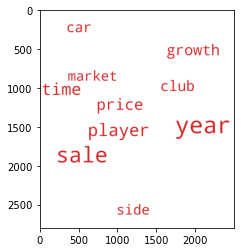

In [107]:
plt.gca().imshow(cloud)
plt.show()

0
1
2
3


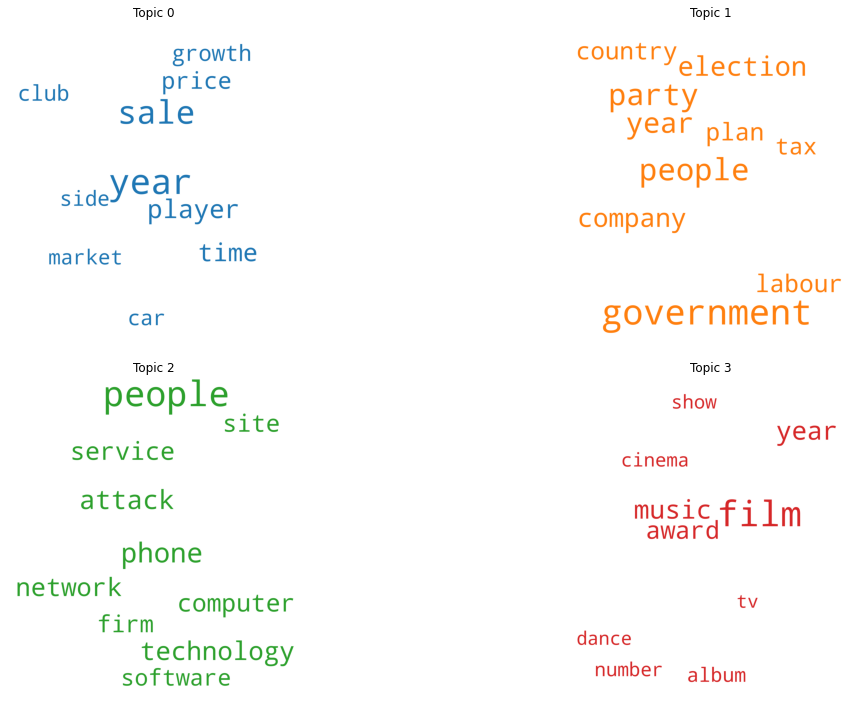

In [101]:
fig, axes = plt.subplots(2,2, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    print(i)
    fig.add_subplot(ax)
    topic_words=dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()